# Breast Cancer

Data Preprocessing

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
# Load Data
file_path = '/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project1/breast_cancer_modified.csv'
data = pd.read_csv(file_path)
data.isnull().sum()
data.dropna()
# Drop the useless 'ID' column
data.drop('ID', axis=1, inplace=True)

# Convert 'Diagnosis' to binary classification (M:1, B:0)
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

# Display the first few rows to verify
# print(data.head())

# Randomly Shuffle the Data
index = np.arange(data.shape[0])
np.random.seed(42)
np.random.shuffle(index)
data_shuffled = data.iloc[index]

# Split the dataset into features and labels
X_noBias = data_shuffled.drop('Diagnosis', axis=1).values
# Add a column of ones to X to include the bias term in the weights vector
X = np.hstack([np.ones((X_noBias.shape[0], 1)), X_noBias])
y = data_shuffled['Diagnosis'].values

# Define the dataset split ratio
train_test_split_ratio = 0.8
train_size = int(X.shape[0] * train_test_split_ratio)

# Split the data into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Logistic Regression Model

In [34]:
import time
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = np.zeros(X_train.shape[1], dtype=float)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)

        for _ in range(self.num_iterations):
            model = np.dot(X, self.weights)
            predictions = self._sigmoid(model)

            dw = (1 / num_samples) * np.dot(X.T, (predictions - y))

            self.weights -= self.learning_rate * dw

    def predict(self, X):
        model = np.dot(X, self.weights)
        predictions = self._sigmoid(model)
        return np.array([1 if i > 0.5 else 0 for i in predictions])

    def accu_eval(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def confusion_matrix(self, y_true, y_pred):
        # Initialize the confusion matrix
        TP, TN, FP, FN = 0, 0, 0, 0

        # Iterate through each true label and predicted label pair
        for true, pred in zip(y_true, y_pred):
            # If the true label is positive and the predicted label is positive
            if true == 1 and pred == 1:
                TP += 1
            # If the true label is negative and the predicted label is negative
            elif true == 0 and pred == 0:
                TN += 1
            # If the true label is positive and the predicted label is negative
            elif true == 1 and pred == 0:
                FN += 1
            # If the true label is negative and the predicted label is positive
            elif true == 0 and pred == 1:
                FP += 1

        # Return the confusion matrix as a tuple
        return TP, TN, FP, FN


Plain Logisctic Regression

Trainset Accuracy: 92.08791208791209%
Testset Accuracy: 90.35087719298247%
Run Time 0.07752466201782227


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


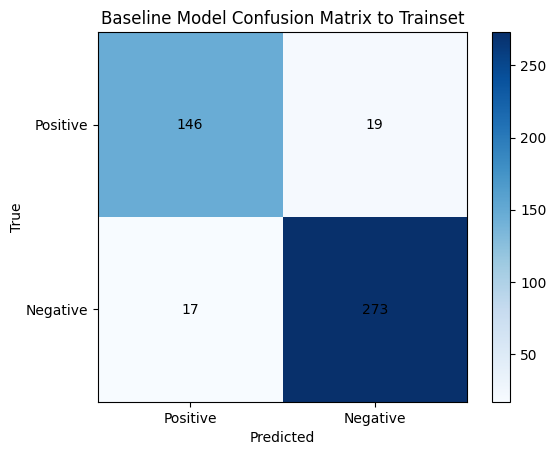

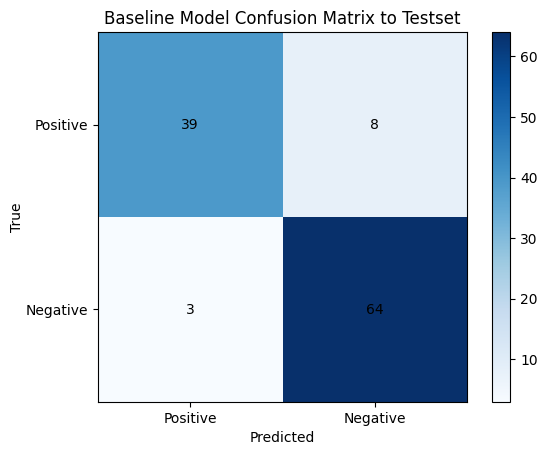

In [35]:
start_time = time.time()
log_reg = LogisticRegression(learning_rate=0.01, num_iterations=1000)
log_reg.fit(X_train, y_train)
end_time = time.time()
predictions_train = log_reg.predict(X_train)
predictions_test = log_reg.predict(X_test)
accuracy_score_train = log_reg.accu_eval(y_train, predictions_train)
accuracy_score_test = log_reg.accu_eval(y_test, predictions_test)
print(f"Trainset Accuracy: {accuracy_score_train * 100}%")
print(f"Testset Accuracy: {accuracy_score_test * 100}%")
print('Run Time', end_time - start_time)
X_train.shape

# Confusion Matrix of the Baseline Model
TP_train, TN_train, FP_train, FN_train = log_reg.confusion_matrix(y_train, predictions_train)
TP_test, TN_test, FP_test, FN_test = log_reg.confusion_matrix(y_test, predictions_test)
# Plot Confusion Matrix
conf_matrix_train = np.array([[TP_train, FN_train],
                [FP_train, TN_train]])

plt.figure()
plt.imshow(conf_matrix_train, cmap='Blues', interpolation='nearest')
plt.colorbar()
# Label axes
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True', labelpad=1)
plt.title('Baseline Model Confusion Matrix to Trainset')
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        plt.text(j, i, str(conf_matrix_train[i, j]), ha='center', va='center', color='black')

conf_matrix_test = np.array([[TP_test, FN_test],
                [FP_test, TN_test]])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project1/final code/BreastCancer_ConfusionMatrix_train.png')

plt.figure()
plt.imshow(conf_matrix_test, cmap='Blues', interpolation='nearest')
plt.colorbar()
# Label axes
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True', labelpad=1)
plt.title('Baseline Model Confusion Matrix to Testset')
for i in range(conf_matrix_test.shape[0]):
    for j in range(conf_matrix_test.shape[1]):
        plt.text(j, i, str(conf_matrix_test[i, j]), ha='center', va='center', color='black')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project1/final code/BreastCancer_ConfusionMatrix_test.png')

Plain Logistic Regression with K-Fold Cross-Validation

In [36]:
def k_fold_validation(k, features, labels):
  num_samples = len(labels)
  samples_per_fold = num_samples // k
  accuracy_scores_train = []
  accuracy_scores_test = []
  # features = data[:,0:30]
  # labels = data[:,30]
  for i in range(k):
      start_index = i * samples_per_fold
      end_index = start_index + samples_per_fold

      X_train_kfold = np.concatenate((features[:start_index], features[end_index:]), axis=0)
      y_train_kfold = np.concatenate((labels[:start_index], labels[end_index:]), axis=0)
      X_test_kfold = features[start_index:end_index]
      y_test_kfold = labels[start_index:end_index]

      # Train the logistic regression model
      model_kfold = LogisticRegression(learning_rate=0.01, num_iterations=1000)
      model_kfold.fit(X_train_kfold, y_train_kfold)

      # Make predictions on the both train and test set
      predictions_train = model_kfold.predict(X_train_kfold)
      predictions_test = model_kfold.predict(X_test_kfold)
      accuracy_kfold_train = model_kfold.accu_eval(y_train_kfold, predictions_train)
      accuracy_kfold_test = model_kfold.accu_eval(y_test_kfold, predictions_test)
      accuracy_scores_train.append(accuracy_kfold_train)
      accuracy_scores_test.append(accuracy_kfold_test)

  average_accuracy_train = np.mean(accuracy_scores_train)
  average_accuracy_test = np.mean(accuracy_scores_test)
  return average_accuracy_train, average_accuracy_test, accuracy_scores_train, accuracy_scores_test

# Implementation
average_accuracy_train, average_accuracy_test, accuracy_scores_train, accuracy_scores_test = k_fold_validation(10, X, y)
print('K Fold Validation with Original Dataset')
print('average_accuracy_train:', average_accuracy_train)
print('average_accuracy_test:', average_accuracy_test)
print('accuracy_scores_train:', accuracy_scores_train)
print('accuracy_scores_test:', accuracy_scores_test)

<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


K Fold Validation with Original Dataset
average_accuracy_train: 0.9120857699805068
average_accuracy_test: 0.9035714285714285
accuracy_scores_train: [0.8888888888888888, 0.9181286549707602, 0.9181286549707602, 0.9161793372319688, 0.9278752436647173, 0.9181286549707602, 0.8830409356725146, 0.9298245614035088, 0.8947368421052632, 0.9259259259259259]
accuracy_scores_test: [0.9464285714285714, 0.9464285714285714, 0.9464285714285714, 0.9821428571428571, 0.8571428571428571, 0.9107142857142857, 0.9107142857142857, 0.8035714285714286, 0.8928571428571429, 0.8392857142857143]


Mutual Information and Polynomial Features

<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.56%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 88.05%


<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Accuracy: 89.10%


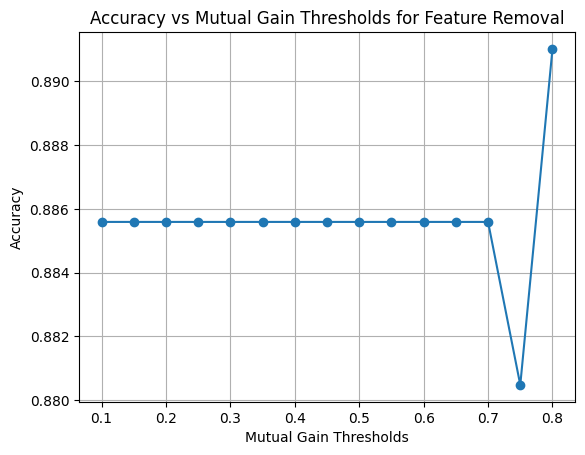

[('Feature_8', 0.9420903069361305), ('Feature_7', 0.9350604299589776), ('Feature_15', 0.9350604299589776), ('Feature_24', 0.9350604299589776), ('Feature_11', 0.9337337383910278), ('Feature_13', 0.9315454914704012), ('Feature_27', 0.9302187999024514), ('Feature_4', 0.9280305529818247), ('Feature_17', 0.9280305529818247), ('Feature_3', 0.9267038614138748), ('Feature_14', 0.925377169845925), ('Feature_16', 0.9231889229252984), ('Feature_26', 0.9183472928687721), ('Feature_20', 0.9174857375160954), ('Feature_28', 0.9148323543801957), ('Feature_6', 0.9091291689709926), ('Feature_21', 0.9003074642106167), ('Feature_23', 0.8985843535052632), ('Feature_30', 0.8915544765281104), ('Feature_12', 0.8642965239721755), ('Feature_22', 0.8634349686194988), ('Feature_1', 0.8607815854835991), ('Feature_18', 0.8585933385629725), ('Feature_29', 0.8453951399613433), ('Feature_10', 0.8361770160635639), ('Feature_2', 0.8357118798482908), ('Feature_19', 0.8181371874054084), ('Feature_5', 0.7761788341876102), 

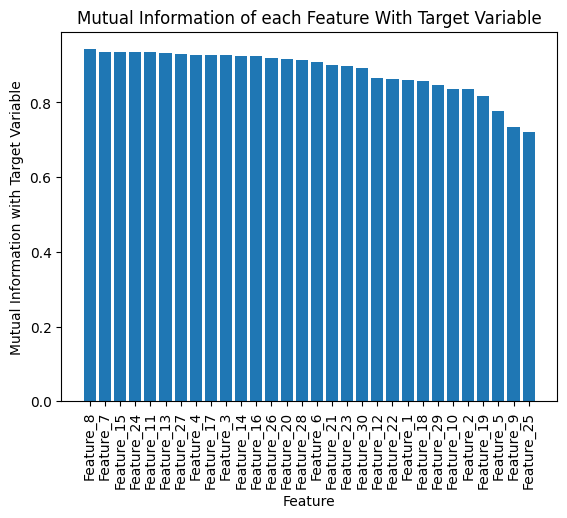

<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


[[0.807 0.912 0.93  0.877 0.877 0.947 0.912 1.    0.912 0.857]]
0.9032581453634085


In [37]:
#Find Mutual Information to compare correlation and Mutual Information
#This function will help determine which features we can remove
#

class KFoldCrossValidation:
    def __init__(self, k=10):
        self.k = k

    def split(self, X, y):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        fold_sizes = np.full(self.k, len(X) // self.k, dtype=int)
        fold_sizes[:len(X) % self.k] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            mask = np.ones(len(X), dtype=bool)
            mask[indices[start:stop]] = False
            X_train, X_val = X[mask], X[~mask]
            y_train, y_val = y[mask], y[~mask]
            yield X_train, X_val, y_train, y_val
            current = stop

    def evaluate(self, model, X, y, metric):
        scores = []
        for X_train, X_val, y_train, y_val in self.split(X, y):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            scores.append(metric(y_val, y_pred))
        return np.mean(scores)

# Accuracy Evaluation Function
def accu_eval(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def entropy_calc(labels):

    unique_labels, num_labels = np.unique(labels, return_counts=True)
    unique_elements = np.unique(labels, return_counts=True)

    unique_labels = unique_elements[0]
    num_labels = unique_elements[1]

    probabilities = num_labels / len(labels)
    entropy = -np.sum(np.log2(probabilities)* probabilities)
    return entropy

def mutual_information_calc(feature, target):
    # Entropy of Y: H(Y)
    target_entropy = entropy_calc(target)

    # Conditional Entropy: H(Y|X)
    feature_entropy = 0
    u_val = np.unique(feature)

    for val in u_val:
        index = np.where(feature == val)[0]
        temp_target = target[index]
        temp_entropy = entropy_calc(temp_target)
        temp_weight = len(temp_target) / len(target)
        feature_entropy = feature_entropy + temp_weight * temp_entropy

    mutual_information = target_entropy - feature_entropy

    return mutual_information

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

mutual_information_array = []

for column in X.columns:
    feature_mutual_info = mutual_information_calc(X[column], y)
    mutual_information_array.append((column, feature_mutual_info))

mutual_information_array.sort(key=lambda x: x[1], reverse=True)

thresholds =  np.arange(0.1, 0.81, 0.05)
accuracy_array=[]
model = LogisticRegression(learning_rate=0.01, num_iterations=1000)

for threshold in thresholds:
    data_temp  = data
    for column, feature_mutual_info in mutual_information_array:
        #print(f"Mutual information between '{column}' and target variable: {feature_mutual_info}")
        if feature_mutual_info < threshold:
          data_temp = data_temp.drop(columns=[column])

    X = data_temp.iloc[:, :-1]
    y = data_temp.iloc[:, -1]


    X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])

    np.random.seed(1)
    indices = np.arange(X_with_bias.shape[0])
    np.random.shuffle(indices)
    X_shuffled = X_with_bias[indices]
    y_shuffled = y[indices]

    split_ratio = 0.8
    split_index = int(X_shuffled.shape[0] * split_ratio)

    X_train, X_test = X_shuffled[:split_index], X_shuffled[split_index:]
    y_train, y_test = y_shuffled[:split_index], y_shuffled[split_index:]

    kfold = KFoldCrossValidation(k=10)
    accuracy = kfold.evaluate(model, X, y, accu_eval)

    print(f"Accuracy: {accuracy * 100:.2f}%")

    accuracy_array.append(accuracy)

plt.plot(thresholds,accuracy_array,marker='o')
plt.xlabel('Mutual Gain Thresholds')
plt.ylabel('Accuracy')
plt.grid(True)
plt.title('Accuracy vs Mutual Gain Thresholds for Feature Removal')
plt.show()

def plot_bar_chart(data):
    num_categories = len(data)
    category_names = [row[0] for row in data]
    category_values = [row[1] for row in data]

    fig, ax = plt.subplots()
    ax.bar(category_names, category_values)

    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.title('Mutual Information of each Feature With Target Variable')
    plt.xticks(rotation='vertical')
    plt.xlabel('Feature')
    plt.ylabel('Mutual Information with Target Variable')
    plt.show()



print(mutual_information_array)
plot_bar_chart(mutual_information_array)

#This one was used to get each FOLDS accuracy, INCLUDE THIS!

class KFoldCrossValidation_Array:
    def __init__(self, k=10):
        self.k = k

    def split(self, X, y):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        fold_sizes = np.full(self.k, len(X) // self.k, dtype=int)
        fold_sizes[:len(X) % self.k] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            mask = np.ones(len(X), dtype=bool)
            mask[indices[start:stop]] = False
            X_train, X_val = X[mask], X[~mask]
            y_train, y_val = y[mask], y[~mask]
            yield X_train, X_val, y_train, y_val
            current = stop

    def evaluate(self, model, X, y, metric):
        scores = []
        for X_train, X_val, y_train, y_val in self.split(X, y):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            scores.append(metric(y_val, y_pred))
        return scores

# Load the data
data = pd.read_csv(file_path)
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

#Remove features with high correlation
data = data.drop(columns = ['ID'])

X = data.drop(columns=['Diagnosis']).values
y = data['Diagnosis'].values  # Convert Diagnosiss to binary

# Lists to store the average accuracy and runtime for each learning rate
accuracies = []
runtimes = []

for column, feature_mutual_info in mutual_information_array:

  if feature_mutual_info > 0.9:
    data[column+'Squared'] = data[column] ** 2

start_time = time.time()
model = LogisticRegression(learning_rate=0.01, num_iterations=1000)
kfold = KFoldCrossValidation_Array(k=10)
accuracy = kfold.evaluate(model, X, y, accu_eval)
accuracies.append(accuracy)
end_time = time.time()
runtimes.append(end_time - start_time)
print(np.around(accuracies, decimals=3))
print(np.mean(accuracies))

Principal Components Analysis Features

In [38]:
data = pd.read_csv(file_path)
data.isnull().sum()
data.dropna()
# Drop the useless 'ID' column
data.drop('ID', axis=1, inplace=True)

# Convert 'Diagnosis' to binary classification (M:1, B:0)
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

# Display the first few rows to verify
# print(data.head())

# Randomly Shuffle the Data
index = np.arange(data.shape[0])
np.random.seed(42)
np.random.shuffle(index)
data_shuffled = data.iloc[index]

# Split the dataset into features and labels
X_noBias = data_shuffled.drop('Diagnosis', axis=1).values
# Add a column of ones to X to include the bias term in the weights vector
X = np.hstack([np.ones((X_noBias.shape[0], 1)), X_noBias])
y = data_shuffled['Diagnosis'].values

# Define the dataset split ratio
train_test_split_ratio = 0.8
train_size = int(X.shape[0] * train_test_split_ratio)

# Split the data into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
def pca(XMat, k, X_test):
    m, n = np.shape(XMat)
    average = np.mean(XMat, axis=0)
    data_adjust = XMat - average
    covX = np.cov(data_adjust.T)
    eigenValue, eigenVec = np.linalg.eig(covX)

    if k > n:
        print('k must be lower than feature number')
        return
    else:
        selectVec = eigenVec[:, :k]
        finalData = np.dot(data_adjust, selectVec)
        reconData = np.dot(finalData, selectVec.T) + average
        average = np.mean(X_test, axis=0)
        # Applying the training PCA for test set
        X_test_pca = X_test - average
        X_test_pca = np.dot(X_test_pca, selectVec)
    return finalData, selectVec, X_test_pca

# PCA without K-fold

X_train_pca, selectVec, X_test_pca = pca(X_train, 4, X_test)
# train and test
start_time = time.time()
log_reg = LogisticRegression(learning_rate=0.01, num_iterations=1000)
log_reg.fit(X_train_pca,y_train)
end_time = time.time()
predictions_train = log_reg.predict(X_train_pca)
predictions_test = log_reg.predict(X_test_pca)
accuracy_score_train = log_reg.accu_eval(y_train, predictions_train)
accuracy_score_test = log_reg.accu_eval(y_test, predictions_test)
print(f"Trainset Accuracy: {accuracy_score_train * 100}%")
print(f"Testset Accuracy: {accuracy_score_test * 100}%")
print('Run Time', end_time - start_time)

# PCA with K-fold
def k_fold_validation_pca(k, features, labels):
  num_samples = len(labels)
  samples_per_fold = num_samples // k
  accuracy_scores_train = []
  accuracy_scores_test = []
  # features = data[:,0:30]
  # labels = data[:,30]
  for i in range(k):
      start_index = i * samples_per_fold
      end_index = start_index + samples_per_fold

      X_train_kfold = np.concatenate((features[:start_index], features[end_index:]), axis=0)
      y_train_kfold = np.concatenate((labels[:start_index], labels[end_index:]), axis=0)
      X_test_kfold = features[start_index:end_index]
      y_test_kfold = labels[start_index:end_index]
      # Get X_train_kfold_pca, X_test_kfold_pca
      X_train_kfold_pca, selectVec, X_test_kfold_pca = pca(X_train_kfold, 4, X_test_kfold)
      # Train the logistic regression model
      model_kfold = LogisticRegression(learning_rate=0.01, num_iterations=1000)
      model_kfold.fit(X_train_kfold_pca, y_train_kfold)

      # Make predictions on the both train and test set
      predictions_train = model_kfold.predict(X_train_kfold_pca)
      predictions_test = model_kfold.predict(X_test_kfold_pca)
      accuracy_kfold_train = model_kfold.accu_eval(y_train_kfold, predictions_train)
      accuracy_kfold_test = model_kfold.accu_eval(y_test_kfold, predictions_test)
      accuracy_scores_train.append(accuracy_kfold_train)
      accuracy_scores_test.append(accuracy_kfold_test)

  average_accuracy_train = np.mean(accuracy_scores_train)
  average_accuracy_test = np.mean(accuracy_scores_test)
  return average_accuracy_train, average_accuracy_test, accuracy_scores_train, accuracy_scores_test
average_accuracy_train, average_accuracy_test, accuracy_scores_train, accuracy_scores_test = k_fold_validation_pca(10, X, y)
print('K Fold Validation with PCA-based Dataset')
print('average_accuracy_train:', average_accuracy_train)
print('average_accuracy_test:', average_accuracy_test)
print('accuracy_scores_train:', accuracy_scores_train)
print('accuracy_scores_test:', accuracy_scores_test)

<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Trainset Accuracy: 95.6043956043956%
Testset Accuracy: 92.10526315789474%
Run Time 0.04594111442565918
K Fold Validation with PCA-based Dataset
average_accuracy_train: 0.9438596491228071
average_accuracy_test: 0.9339285714285716
accuracy_scores_train: [0.949317738791423, 0.9473684210526315, 0.949317738791423, 0.9376218323586745, 0.949317738791423, 0.9434697855750487, 0.935672514619883, 0.935672514619883, 0.9278752436647173, 0.9629629629629629]
accuracy_scores_test: [0.9642857142857143, 0.9464285714285714, 0.9821428571428571, 0.9642857142857143, 0.9464285714285714, 0.9285714285714286, 0.9464285714285714, 0.8928571428571429, 0.8571428571428571, 0.9107142857142857]


Learning Rates and Iterations Compared with Accuracy

<ipython-input-34-7a10af5c5391>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


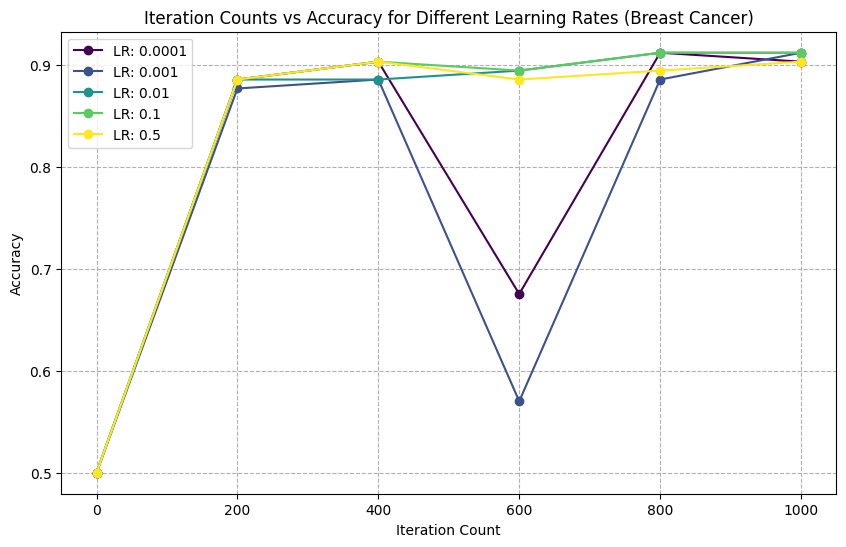

In [39]:
from matplotlib.cm import viridis
from matplotlib.colors import to_hex

# Load data
df = pd.read_csv(file_path)

# Preprocess data
df = df.drop(columns=['ID'])  # Drop the 'ID' column
df['Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})  # Encode the target variable

# Split the data into features (X) and target (y)
X = df.drop(columns=['Diagnosis']).values
y = df['Diagnosis'].values

# Shuffle and split the dataset manually
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
split_idx = int(X.shape[0] * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

iteration_counts = np.arange(0, 1001, 200)  # Iteration counts from 0 to 1000 with step 200
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1, 0.5]  # Different learning rates to test

# Initialize a dictionary to store accuracies for each learning rate across iteration counts
accuracies_by_lr = {lr: [] for lr in learning_rates}

# Evaluate logistic regression for each learning rate and iteration count
for lr in learning_rates:
    accuracies = []
    for it_count in iteration_counts:
        log_reg = LogisticRegression(learning_rate=lr, num_iterations=it_count)
        if it_count == 0:
            # Skip the training process for 0 iterations, assume baseline accuracy
            accuracies.append(0.5)  # Assuming baseline accuracy without training
            continue
        log_reg.fit(X_train, y_train)
        # Predict on the dataset and calculate accuracy
        y_pred = log_reg.predict(X_test)
        accuracy = log_reg.accu_eval(y_test, y_pred)
        accuracies.append(accuracy)

    accuracies_by_lr[lr] = accuracies

# Plotting the results
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(learning_rates)))

for lr, color in zip(learning_rates, colors):
    plt.plot(iteration_counts, accuracies_by_lr[lr], marker='o', color=color, label=f'LR: {lr}')

plt.title('Iteration Counts vs Accuracy for Different Learning Rates (Breast Cancer)')
plt.xlabel('Iteration Count')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Ionosphere

Data Preprocessing

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
# Load the data
file_path = '/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project1/ionosphere_modified.csv'
data = pd.read_csv(file_path)

# Drop the all zero 'Feature_2' column
# data.drop('Feature_2', axis=1, inplace=True)

# Convert 'Label' to binary classification (M:1, B:0)
data['Label'] = data['Label'].map({'b': 1, 'g': 0})

# Display the first few rows to verify
# print(data.head())

# Shuffle the data
index = np.arange(data.shape[0])
np.random.seed(42)
np.random.shuffle(index)
data_shuffled = data.iloc[index]

# Split the dataset into features and labels
X_noBias = data_shuffled.drop('Label', axis=1).values
# Add a column of ones to X to include the bias term in the weights vector
X = np.hstack([np.ones((X_noBias.shape[0], 1)), X_noBias])
y = data_shuffled['Label'].values

# Define the dataset split ratio
train_test_split_ratio = 0.8
train_size = int(X.shape[0] * train_test_split_ratio)

# Split the data into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Logistic Regression Model

In [41]:
import numpy as np
import time
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = np.zeros(X_train.shape[1], dtype=float)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)

        for _ in range(self.num_iterations):
            model = np.dot(X, self.weights)
            predictions = self._sigmoid(model)

            dw = (1 / num_samples) * np.dot(X.T, (predictions - y))

            self.weights -= self.learning_rate * dw

    def predict(self, X):
        model = np.dot(X, self.weights)
        predictions = self._sigmoid(model)
        return np.array([1 if i > 0.5 else 0 for i in predictions])

    def accu_eval(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def confusion_matrix(self, y_true, y_pred):
        # Initialize the confusion matrix
        TP, TN, FP, FN = 0, 0, 0, 0

        # Iterate through each true label and predicted label pair
        for true, pred in zip(y_true, y_pred):
            # If the true label is positive and the predicted label is positive
            if true == 1 and pred == 1:
                TP += 1
            # If the true label is negative and the predicted label is negative
            elif true == 0 and pred == 0:
                TN += 1
            # If the true label is positive and the predicted label is negative
            elif true == 1 and pred == 0:
                FN += 1
            # If the true label is negative and the predicted label is positive
            elif true == 0 and pred == 1:
                FP += 1

        # Return the confusion matrix as a tuple
        return TP, TN, FP, FN

Plain Logisctic Regression

Trainset Accuracy: 84.28571428571429%
Testset Accuracy: 88.73239436619718%
Run Time 0.1309661865234375


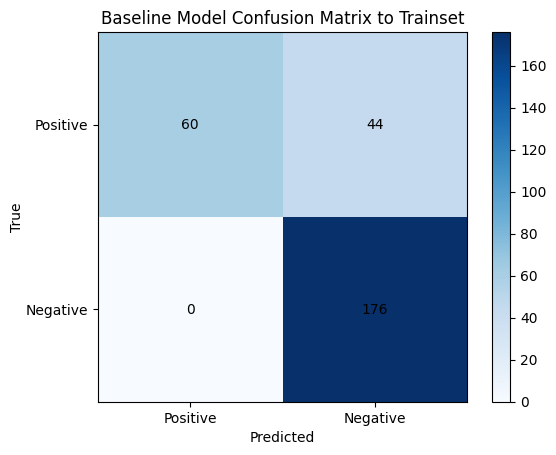

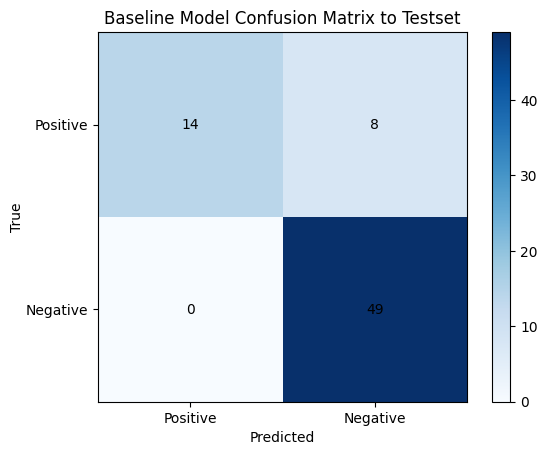

In [42]:
start_time = time.time()
log_reg = LogisticRegression(learning_rate=0.01, num_iterations=1000)
log_reg.fit(X_train, y_train)
end_time = time.time()
predictions_train = log_reg.predict(X_train)
predictions_test = log_reg.predict(X_test)
accuracy_score_train = log_reg.accu_eval(y_train, predictions_train)
accuracy_score_test = log_reg.accu_eval(y_test, predictions_test)
print(f"Trainset Accuracy: {accuracy_score_train * 100}%")
print(f"Testset Accuracy: {accuracy_score_test * 100}%")
print('Run Time', end_time - start_time)

# Confusion Matrix
TP_train, TN_train, FP_train, FN_train = log_reg.confusion_matrix(y_train, predictions_train)
TP_test, TN_test, FP_test, FN_test = log_reg.confusion_matrix(y_test, predictions_test)
# Plot Confusion Matrix
conf_matrix_train = np.array([[TP_train, FN_train],
                [FP_train, TN_train]])

plt.figure()
plt.imshow(conf_matrix_train, cmap='Blues', interpolation='nearest')
plt.colorbar()
# Label axes
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True', labelpad=1)
plt.title('Baseline Model Confusion Matrix to Trainset')
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        plt.text(j, i, str(conf_matrix_train[i, j]), ha='center', va='center', color='black')

conf_matrix_test = np.array([[TP_test, FN_test],
                [FP_test, TN_test]])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project1/final code/plots/Ionosphere_ConfusionMatrix_train.png')

plt.figure()
plt.imshow(conf_matrix_test, cmap='Blues', interpolation='nearest')
plt.colorbar()
# Label axes
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True', labelpad=1)
plt.title('Baseline Model Confusion Matrix to Testset')
for i in range(conf_matrix_test.shape[0]):
    for j in range(conf_matrix_test.shape[1]):
        plt.text(j, i, str(conf_matrix_test[i, j]), ha='center', va='center', color='black')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECSE551 Machine Learning for Engineers/project1/final code/plots/Ionosphere_ConfusionMatrix_test.png')

Plain Logistic Regression with K-Fold Cross-Validation

In [43]:
def k_fold_validation(k, features, labels):
  num_samples = len(labels)
  samples_per_fold = num_samples // k
  accuracy_scores_train = []
  accuracy_scores_test = []
  # features = data[:,0:30]
  # labels = data[:,30]
  for i in range(k):
      start_index = i * samples_per_fold
      end_index = start_index + samples_per_fold

      X_train_kfold = np.concatenate((features[:start_index], features[end_index:]), axis=0)
      y_train_kfold = np.concatenate((labels[:start_index], labels[end_index:]), axis=0)
      X_test_kfold = features[start_index:end_index]
      y_test_kfold = labels[start_index:end_index]

      # Train the logistic regression model
      model_kfold = LogisticRegression(learning_rate=0.01, num_iterations=1000)
      model_kfold.fit(X_train_kfold, y_train_kfold)

      # Make predictions on the both train and test set
      predictions_train = model_kfold.predict(X_train_kfold)
      predictions_test = model_kfold.predict(X_test_kfold)
      accuracy_kfold_train = model_kfold.accu_eval(y_train_kfold, predictions_train)
      accuracy_kfold_test = model_kfold.accu_eval(y_test_kfold, predictions_test)
      accuracy_scores_train.append(accuracy_kfold_train)
      accuracy_scores_test.append(accuracy_kfold_test)

  average_accuracy_train = np.mean(accuracy_scores_train)
  average_accuracy_test = np.mean(accuracy_scores_test)
  return average_accuracy_train, average_accuracy_test, accuracy_scores_train, accuracy_scores_test

# Implementation
average_accuracy_train, average_accuracy_test, accuracy_scores_train, accuracy_scores_test = k_fold_validation(10, X, y)
print('K Fold Validation with Original Dataset')
print('average_accuracy_train:', average_accuracy_train)
print('average_accuracy_test:', average_accuracy_test)
print('accuracy_scores_train:', accuracy_scores_train)
print('accuracy_scores_test:', accuracy_scores_test)

K Fold Validation with Original Dataset
average_accuracy_train: 0.8465189873417721
average_accuracy_test: 0.822857142857143
accuracy_scores_train: [0.8544303797468354, 0.8417721518987342, 0.8417721518987342, 0.8481012658227848, 0.8512658227848101, 0.8449367088607594, 0.8544303797468354, 0.8417721518987342, 0.8449367088607594, 0.8417721518987342]
accuracy_scores_test: [0.7714285714285715, 0.8, 0.8285714285714286, 0.8, 0.8, 0.8857142857142857, 0.7142857142857143, 0.8571428571428571, 0.8857142857142857, 0.8857142857142857]


Mutual Information and Polynomial Features

Accuracy: 77.77%
Accuracy: 77.77%
Accuracy: 78.63%
Accuracy: 78.63%
Accuracy: 78.63%
Accuracy: 78.63%
Accuracy: 78.63%
Accuracy: 78.63%
Accuracy: 78.63%
Accuracy: 78.63%
Accuracy: 78.63%
Accuracy: 78.63%
Accuracy: 77.49%
Accuracy: 76.65%
Accuracy: 74.37%


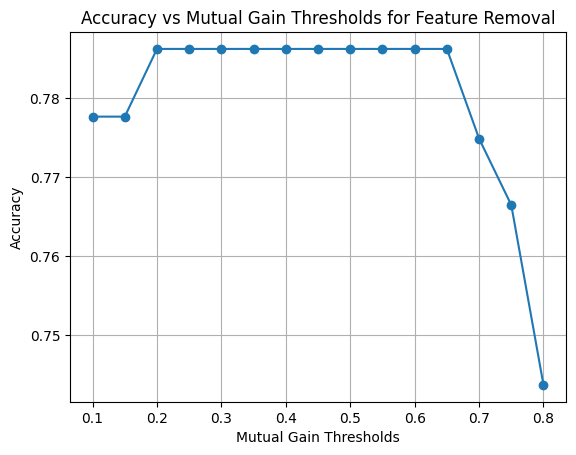

[('Feature_28', 0.869546464309322), ('Feature_18', 0.8543171597421524), ('Feature_4', 0.8423547667020904), ('Feature_6', 0.8386114485670656), ('Feature_16', 0.8356051342402557), ('Feature_34', 0.8346526556893881), ('Feature_14', 0.8300726272142366), ('Feature_22', 0.8286665266352518), ('Feature_26', 0.824346349602943), ('Feature_8', 0.822354091551176), ('Feature_24', 0.8189275508820714), ('Feature_10', 0.8134922394887418), ('Feature_33', 0.8021313835408053), ('Feature_32', 0.8006636023681559), ('Feature_30', 0.7987039945957239), ('Feature_12', 0.7973953095293582), ('Feature_20', 0.7878642471581656), ('Feature_25', 0.7776027446599737), ('Feature_27', 0.7774633236810264), ('Feature_29', 0.7732951334160671), ('Feature_21', 0.7670323514076287), ('Feature_9', 0.7600064684126641), ('Feature_19', 0.7535296300612085), ('Feature_23', 0.7489207490166916), ('Feature_31', 0.7452693941854529), ('Feature_17', 0.7408001732611547), ('Feature_11', 0.7353632040673432), ('Feature_7', 0.7284139076582001),

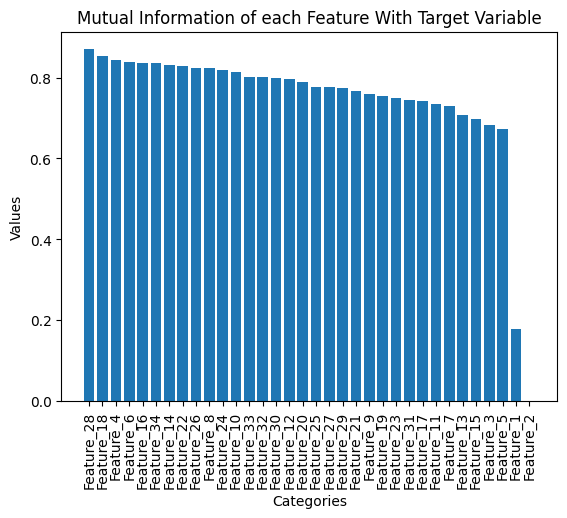

[[0.722 0.8   0.686 0.714 0.714 0.743 0.857 0.914 0.829 0.771]]
0.775079365079365


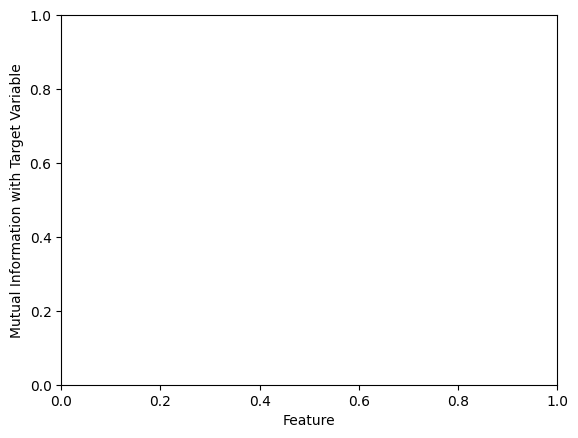

In [44]:
#Find Mutual Information to compare correlation and Mutual Information
#This function will help determine which features we can remove

class KFoldCrossValidation:
    def __init__(self, k=10):
        self.k = k

    def split(self, X, y):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        fold_sizes = np.full(self.k, len(X) // self.k, dtype=int)
        fold_sizes[:len(X) % self.k] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            mask = np.ones(len(X), dtype=bool)
            mask[indices[start:stop]] = False
            X_train, X_val = X[mask], X[~mask]
            y_train, y_val = y[mask], y[~mask]
            yield X_train, X_val, y_train, y_val
            current = stop

    def evaluate(self, model, X, y, metric):
        scores = []
        for X_train, X_val, y_train, y_val in self.split(X, y):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            scores.append(metric(y_val, y_pred))
        return np.mean(scores)


def entropy_calc(labels):

    unique_labels, num_labels = np.unique(labels, return_counts=True)
    unique_elements = np.unique(labels, return_counts=True)

    unique_labels = unique_elements[0]
    num_labels = unique_elements[1]

    probabilities = num_labels / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def mutual_information_calc(feature, target):
    # Entropy of Y: H(Y)
    target_entropy = entropy_calc(target)

    # Conditional Entropy: H(Y|X)
    feature_entropy = 0
    u_val = np.unique(feature)

    for val in u_val:
        index = np.where(feature == val)[0]
        temp_target = target[index]
        temp_entropy = entropy_calc(temp_target)
        temp_weight = len(temp_target) / len(target)
        feature_entropy = feature_entropy + temp_weight * temp_entropy

    mutual_information = target_entropy - feature_entropy

    return mutual_information

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

mutual_information_array = []

for column in X.columns:
    feature_mutual_info = mutual_information_calc(X[column], y)
    mutual_information_array.append((column, feature_mutual_info))

mutual_information_array.sort(key=lambda x: x[1], reverse=True)

thresholds =  np.arange(0.1, 0.81, 0.05)
accuracy_array=[]
model = LogisticRegression(learning_rate=0.01, num_iterations=1000)

for threshold in thresholds:
    data_temp  = data
    for column, feature_mutual_info in mutual_information_array:
        #print(f"Mutual information between '{column}' and target variable: {feature_mutual_info}")
        if feature_mutual_info < threshold:
          data_temp = data_temp.drop(columns=[column])

    X = data_temp.iloc[:, :-1]
    y = data_temp.iloc[:, -1]


    X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])

    np.random.seed(1)
    indices = np.arange(X_with_bias.shape[0])
    np.random.shuffle(indices)
    X_shuffled = X_with_bias[indices]
    y_shuffled = y[indices]

    split_ratio = 0.8
    split_index = int(X_shuffled.shape[0] * split_ratio)

    X_train, X_test = X_shuffled[:split_index], X_shuffled[split_index:]
    y_train, y_test = y_shuffled[:split_index], y_shuffled[split_index:]

    kfold = KFoldCrossValidation(k=10)
    accuracy = kfold.evaluate(model, X, y, accu_eval)

    print(f"Accuracy: {accuracy * 100:.2f}%")

    accuracy_array.append(accuracy)

plt.plot(thresholds,accuracy_array,marker='o')
plt.xlabel('Mutual Gain Thresholds')
plt.ylabel('Accuracy')
plt.grid(True)
plt.title('Accuracy vs Mutual Gain Thresholds for Feature Removal')
plt.show()
def plot_bar_chart(data):
    num_categories = len(data)
    category_names = [row[0] for row in data]
    category_values = [row[1] for row in data]

    fig, ax = plt.subplots()
    ax.bar(category_names, category_values)

    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.title('Mutual Information of each Feature With Target Variable')
    plt.xticks(rotation='vertical')
    plt.show()
    plt.xlabel('Feature')
    plt.ylabel('Mutual Information with Target Variable')


print(mutual_information_array)
plot_bar_chart(mutual_information_array)

#Finds Kfold accuracy across each fold and overall accuracy

class KFoldCrossValidation_Array:
    def __init__(self, k=10):
        self.k = k

    def split(self, X, y):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        fold_sizes = np.full(self.k, len(X) // self.k, dtype=int)
        fold_sizes[:len(X) % self.k] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            mask = np.ones(len(X), dtype=bool)
            mask[indices[start:stop]] = False
            X_train, X_val = X[mask], X[~mask]
            y_train, y_val = y[mask], y[~mask]
            yield X_train, X_val, y_train, y_val
            current = stop

    def evaluate(self, model, X, y, metric):
        scores = []
        for X_train, X_val, y_train, y_val in self.split(X, y):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            scores.append(metric(y_val, y_pred))
        return scores

# Load the data
data = pd.read_csv(file_path)

# Convert 'Diagnosis' to binary (M:1, B:0)
data['Label'] = data['Label'].map({'g': 1, 'b': 0})

X = data.drop(columns=['Label']).values
y = data['Label'].values  # Convert labels to binary

# Lists to store the average accuracy and runtime for each learning rate
accuracies = []
runtimes = []

for column, feature_mutual_info in mutual_information_array:

  if feature_mutual_info > 0.7:
    data[column+'Squared'] = data[column] ** 2

start_time = time.time()
model = LogisticRegression(learning_rate=0.01, num_iterations=1000)
kfold = KFoldCrossValidation_Array(k=10)
accuracy = kfold.evaluate(model, X, y, accu_eval)
accuracies.append(accuracy)
end_time = time.time()
runtimes.append(end_time - start_time)
print(np.around(accuracies, decimals=3))
print(np.mean(accuracies))


Principal Components Analysis

Learning Rates and Iterations Compared with Accuracy

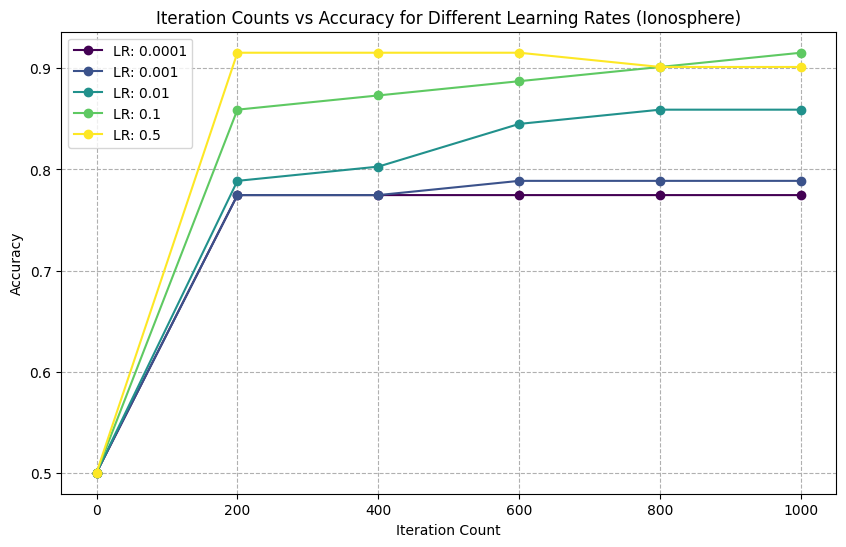

In [46]:
from matplotlib.cm import viridis
from matplotlib.colors import to_hex

# Load data
df = pd.read_csv(file_path)

# Preprocess data
df['Label'] = df['Label'].map({'g': 1, 'b': 0})

# Split the data into features (X) and target (y)
X = df.drop(columns=['Label']).values
y = df['Label'].values

# Shuffle and split the dataset manually
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
split_idx = int(X.shape[0] * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

iteration_counts = np.arange(0, 1001, 200)  # Iteration counts from 0 to 1000 with step 200
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1, 0.5]  # Different learning rates to test

# Initialize a dictionary to store accuracies for each learning rate across iteration counts
accuracies_by_lr = {lr: [] for lr in learning_rates}

# Evaluate logistic regression for each learning rate and iteration count
for lr in learning_rates:
    accuracies = []
    for it_count in iteration_counts:
        log_reg = LogisticRegression(learning_rate=lr, num_iterations=it_count)
        if it_count == 0:
            # Skip the training process for 0 iterations, assume baseline accuracy
            accuracies.append(0.5)  # Assuming baseline accuracy without training
            continue
        log_reg.fit(X_train, y_train)
        # Predict on the dataset and calculate accuracy
        y_pred = log_reg.predict(X_test)
        accuracy = log_reg.accu_eval(y_test, y_pred)
        accuracies.append(accuracy)

    accuracies_by_lr[lr] = accuracies

# Plotting the results
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(learning_rates)))

for lr, color in zip(learning_rates, colors):
    plt.plot(iteration_counts, accuracies_by_lr[lr], marker='o', color=color, label=f'LR: {lr}')

plt.title('Iteration Counts vs Accuracy for Different Learning Rates (Ionosphere)')
plt.xlabel('Iteration Count')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()